In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#  Step 2 : Organize Images and Annotations

import os
import shutil

# Base directories
base_dir = '/content/HealthGPT-V2'
vindr_root = '/content/drive/MyDrive/VinDr-CXR/vindr-cxr/1.0.0'
output_dataset_dir = os.path.join(base_dir, 'datasets', 'VinDr-CXR')

# Create folders
os.makedirs(os.path.join(output_dataset_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dataset_dir, 'annotations'), exist_ok=True)

# Copy all train & test images
for folder in ['train', 'test']:
    img_src = os.path.join(vindr_root, folder)
    if os.path.exists(img_src):
        for fname in os.listdir(img_src):
            if fname.endswith('.dicom') or fname.endswith('.dcm') or fname.endswith('.jpg') or fname.endswith('.png'):
                shutil.copy(os.path.join(img_src, fname), os.path.join(output_dataset_dir, 'images', fname))

# Copy annotation files
ann_src_dir = os.path.join(vindr_root, 'annotations')
if os.path.exists(ann_src_dir):
    for fname in os.listdir(ann_src_dir):
        shutil.copy(os.path.join(ann_src_dir, fname), os.path.join(output_dataset_dir, 'annotations', fname))

print(" All images and annotations copied to HealthGPT-V2/datasets/VinDr-CXR.")


 All images and annotations copied to HealthGPT-V2/datasets/VinDr-CXR.


In [9]:
# Step 3: Convert Annotations to Question-Answer Pairs

import pandas as pd
import json
from tqdm import tqdm

#  Corrected annotation path
ann_path = '/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv'
df = pd.read_csv(ann_path)

# Convert to VQA format
qa_pairs = []
for image_id, group in tqdm(df.groupby('image_id')):
    question = "What abnormalities are visible in this chest X-ray?"
    answers = list(group['class_name'].unique())

    boxes = []
    for _, row in group.iterrows():
        boxes.append({
            "label": row['class_name'],
            "bbox": [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
        })

    qa_pairs.append({
        "image_id": image_id,
        "question": question,
        "answers": answers,
        "boxes": boxes
    })

# Save output
qa_output_path = '/content/HealthGPT-V2/datasets/VinDr-CXR/vqa_annotations.json'
with open(qa_output_path, 'w') as f:
    json.dump(qa_pairs, f, indent=2)

print(f" VQA annotations saved to {qa_output_path}")


100%|██████████| 15000/15000 [00:05<00:00, 2537.28it/s]


 VQA annotations saved to /content/HealthGPT-V2/datasets/VinDr-CXR/vqa_annotations.json


##Implementation

Used “What abnormalities…” questions

Saved as boxes list with coordinates

Used .unique() for multi-answer handling

Matches expected structure for fine-tuning



In [10]:
# ✅ Step 4 : Copy Only 1000 DICOM Images to Save Time

import pandas as pd
from tqdm import tqdm

# Load annotations
ann_path = '/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv'
df = pd.read_csv(ann_path)

# Get first 1000 unique annotated image_ids
selected_ids = df['image_id'].drop_duplicates().head(1000).tolist()

# Paths
src_image_dir = '/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/train'
target_dir = '/content/HealthGPT-V2/datasets/unified_dataset/images_vindr'
os.makedirs(target_dir, exist_ok=True)

# Copy DICOMs with annotations
copied = 0
for image_id in tqdm(selected_ids):
    dicom_file = image_id + '.dicom'
    src_path = os.path.join(src_image_dir, dicom_file)
    if os.path.exists(src_path):
        shutil.copy(src_path, os.path.join(target_dir, dicom_file))
        copied += 1

print(f"✅ Copied {copied} annotated DICOMs to: {target_dir}")


100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it]

✅ Copied 1000 annotated DICOMs to: /content/HealthGPT-V2/datasets/unified_dataset/images_vindr


In [11]:
# ✅ Install required packages
!pip install pydicom scikit-image


In [12]:
# ✅ Step 5: Apply Histogram Matching from VL-Health (dummy) to 500 VinDr-CXR images

# Install required packages
!pip install -q pydicom scikit-image

import pydicom
import numpy as np
from PIL import Image
from skimage.exposure import match_histograms
import os
from tqdm import tqdm
import random

# Paths
vindr_img_dir = '/content/HealthGPT-V2/datasets/unified_dataset/images_vindr'
output_dir = '/content/HealthGPT-V2/datasets/unified_dataset/images_vindr_matched'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Select 500 random DICOM images from the 1000
all_dicom_files = [f for f in os.listdir(vindr_img_dir) if f.endswith('.dicom')]
selected_files = random.sample(all_dicom_files, 500)

# Step 2: Load dummy reference image (first file from selection)
ref_path = os.path.join(vindr_img_dir, selected_files[0])
ref_dicom = pydicom.dcmread(ref_path)
target_img = ref_dicom.pixel_array.astype(np.uint8)

# Step 3: Perform histogram matching and save as .png
for fname in tqdm(selected_files, desc="Histogram Matching"):
    try:
        dicom_path = os.path.join(vindr_img_dir, fname)
        dicom = pydicom.dcmread(dicom_path)
        img_array = dicom.pixel_array.astype(np.uint8)

        matched = match_histograms(img_array, target_img, channel_axis=None)
        matched = np.clip(matched, 0, 255).astype(np.uint8)

        # Save as .png to output_dir
        out_path = os.path.join(output_dir, fname.replace('.dicom', '.png'))
        Image.fromarray(matched).save(out_path)
    except Exception as e:
        print(f"⚠️ Failed on {fname}: {e}")

print(f"✅ Histogram matching completed for {len(selected_files)} images and saved to:", output_dir)


Histogram Matching: 100%|██████████| 500/500 [11:01<00:00,  1.32s/it]

✅ Histogram matching completed for 500 images and saved to: /content/HealthGPT-V2/datasets/unified_dataset/images_vindr_matched


In [13]:
#Step 6: Region Alignment Head - CNN + Attention + Prediction
import torch
import torch.nn as nn

class RegionAlignmentHead(nn.Module):
    def __init__(self, image_feat_dim=512, text_feat_dim=512, hidden_dim=256, num_concepts=14):
        super().__init__()

        # Fuse image + text features
        self.fusion = nn.Sequential(
            nn.Linear(image_feat_dim + text_feat_dim, hidden_dim),
            nn.ReLU(),
        )

        # Predict bounding box [x_min, y_min, x_max, y_max]
        self.bbox_pred = nn.Linear(hidden_dim, 4)

        # Predict associated concept class
        self.classifier = nn.Linear(hidden_dim, num_concepts)

    def forward(self, image_feats, text_feats):
        # Concatenate image-text features
        x = torch.cat([image_feats, text_feats], dim=-1)
        x = self.fusion(x)

        bbox = self.bbox_pred(x)              # shape: (B, 4)
        logits = self.classifier(x)           # shape: (B, num_concepts)

        return bbox, logits


In [14]:
# Helper Function: Supervised Loss for Region Alignment

import torch.nn.functional as F

def compute_region_alignment_loss(bbox_preds, logits, gt_boxes, gt_labels, alpha=1.0, beta=1.0):
    """
    Compute total loss for region alignment.

    Args:
        bbox_preds (Tensor): Predicted bounding boxes (B, 4)
        logits (Tensor): Predicted class scores (B, num_classes)
        gt_boxes (Tensor): Ground-truth bounding boxes (B, 4)
        gt_labels (Tensor): Ground-truth class indices (B,)
        alpha (float): Weight for box loss
        beta (float): Weight for class loss

    Returns:
        total_loss (Tensor): Weighted sum of box and class losses
        box_loss (Tensor): L1 loss for bounding boxes
        class_loss (Tensor): Cross-entropy loss for class predictions
    """
    box_loss = F.l1_loss(bbox_preds, gt_boxes)
    class_loss = F.cross_entropy(logits, gt_labels)
    total_loss = alpha * box_loss + beta * class_loss
    return total_loss, box_loss, class_loss


In [15]:
# Step 7: Wrap BERT with H-LoRA using PEFT

from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModel

# Load base BERT model for text feature extraction (not classification)
base_model = AutoModel.from_pretrained("bert-base-uncased")

# Define LoRA configuration for feature extraction
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # ⚠️ Not SEQ_CLS, since we extract features
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

# Apply LoRA on top of BERT
lora_model = get_peft_model(base_model, lora_config)

# Print trainable parameters — only LoRA layers should be active
lora_model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'TypeError: Failed to fetch'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

trainable params: 294,912 || all params: 109,777,152 || trainable%: 0.2686


##Summary of Step 7
BERT loaded for feature extraction

H-LoRA (via PEFT LoRAConfig)

Only LoRA layers are trainable

No classification head involved yet

In [16]:
# ✅ Updated Step 8: Inject LoRA-Wrapped BERT into JsonBBoxAnswerModel (supports external CLIP)

import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

class JsonBBoxAnswerModel(nn.Module):
    def __init__(self, lora_text_model, clip_model=None, processor=None, freeze_vision=True):
        super().__init__()

        # ✅ Use external CLIP model if provided
        if clip_model is not None:
            self.clip_model = clip_model
        else:
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

        # ✅ Use external CLIP processor if provided
        if processor is not None:
            self.processor = processor
        else:
            self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

        # ✅ Use LoRA-wrapped BERT
        self.text_encoder = lora_text_model

        # Classification head: ViT + BERT CLS → binary prediction
        self.classifier = nn.Linear(self.clip_model.config.projection_dim + 768, 2)

        # Bounding box regression head
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.clip_model.config.projection_dim + 768, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

        # Optional: freeze CLIP vision encoder
        if freeze_vision:
            for param in self.clip_model.vision_model.parameters():
                param.requires_grad = False

    def forward(self, images, texts):
        # Extract vision features
        vision_outputs = self.clip_model.vision_model(pixel_values=images)
        vision_features = vision_outputs.pooler_output

        # Extract text features (CLS token from BERT)
        text_outputs = self.text_encoder(**texts)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Combine vision + text features
        combined = torch.cat([vision_features, text_features], dim=1)

        # Predict class and bounding box
        logits = self.classifier(combined)
        bbox = self.bbox_regressor(combined)

        return logits, bbox


In [17]:
# Step 9: Reinitialize Model, Losses, and Optimizer (with safe fallback if LoRA is missing)

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel
from peft import PeftModel

# === CONFIG ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_base_name = "openai/clip-vit-base-patch32"
lora_weights_path = "/content/drive/MyDrive/lora_checkpoint"  # <-- Update this if you have LoRA

# === Load CLIP components ===
clip_processor = CLIPProcessor.from_pretrained(clip_base_name)
clip_model = CLIPModel.from_pretrained(clip_base_name)

# === Attempt to load LoRA-enhanced text encoder ===
try:
    lora_model = PeftModel.from_pretrained(clip_model.text_model, lora_weights_path)
    print("✅ LoRA model loaded from checkpoint.")
except Exception as e:
    print(f"⚠️ LoRA checkpoint not found. Using base CLIP text model instead. Error: {e}")
    lora_model = clip_model.text_model  # ✅ Safe fallback to base model

# === Initialize JsonBBoxAnswerModel ===
model = JsonBBoxAnswerModel(
    lora_text_model=lora_model,
    clip_model=clip_model,
    processor=clip_processor,
    freeze_vision=False
).to(device)

# === Define Loss Functions ===
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()

# === Optimizer: Only train LoRA + regressor/classifier heads ===
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=1e-4)

print("✅ Model, loss functions, and optimizer initialized (using base or LoRA as available).")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

⚠️ LoRA checkpoint not found. Using base CLIP text model instead. Error: Can't find 'adapter_config.json' at '/content/drive/MyDrive/lora_checkpoint'
✅ Model, loss functions, and optimizer initialized (using base or LoRA as available).


In [18]:
from tqdm import tqdm

def train(model, dataloader, optimizer, classification_loss_fn, bbox_loss_fn, device="cuda"):
    model.train()
    total_cls_loss = 0
    total_bbox_loss = 0

    for batch in tqdm(dataloader):
        images = batch["pixel_values"].to(device)          # preprocessed DICOM
        report_inputs = {k: v.to(device) for k, v in batch["report_inputs"].items()}  # tokenized report
        labels = batch["labels"].to(device)                # e.g., 0/1 (abnormal/normal)
        bbox_targets = batch["bboxes"].to(device)          # [x, y, w, h] scaled to image size

        optimizer.zero_grad()

        # Forward pass
        cls_logits, bbox_preds = model(images, report_inputs)

        # Compute losses
        loss_cls = classification_loss_fn(cls_logits, labels)
        loss_bbox = bbox_loss_fn(bbox_preds, bbox_targets)

        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()

        total_cls_loss += loss_cls.item()
        total_bbox_loss += loss_bbox.item()

    avg_cls = total_cls_loss / len(dataloader)
    avg_bbox = total_bbox_loss / len(dataloader)
    print(f"[Train] Classification Loss: {avg_cls:.4f} | BBox Loss: {avg_bbox:.4f}")


In [19]:
# Step 10A: Define IoU Metric (Improved with batch size safety)

def compute_iou(pred_boxes, true_boxes):
    """Compute IoU for a batch of predicted and ground truth boxes"""
    # Boxes: (B, 4) format = [x, y, w, h]
    assert pred_boxes.shape == true_boxes.shape, "Mismatched shapes for IoU computation"

    pred_x1 = pred_boxes[:, 0]
    pred_y1 = pred_boxes[:, 1]
    pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2]
    pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3]

    true_x1 = true_boxes[:, 0]
    true_y1 = true_boxes[:, 1]
    true_x2 = true_boxes[:, 0] + true_boxes[:, 2]
    true_y2 = true_boxes[:, 1] + true_boxes[:, 3]

    inter_x1 = torch.max(pred_x1, true_x1)
    inter_y1 = torch.max(pred_y1, true_y1)
    inter_x2 = torch.min(pred_x2, true_x2)
    inter_y2 = torch.min(pred_y2, true_y2)

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    true_area = (true_x2 - true_x1) * (true_y2 - true_y1)
    union_area = pred_area + true_area - inter_area

    iou = inter_area / (union_area + 1e-6)
    return iou


In [20]:
# Step 10B: Evaluation Loop – Accuracy, F1, Precision, Recall, Mean IoU (Improved)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, dataloader, device="cuda"):
    model.eval()

    all_preds = []
    all_labels = []
    all_ious = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["pixel_values"].to(device)
            report_inputs = {k: v.to(device) for k, v in batch["report_inputs"].items()}
            labels = batch["labels"].to(device)
            bbox_targets = batch["bboxes"].to(device)

            cls_logits, bbox_preds = model(images, report_inputs)

            # Classification predictions
            preds = torch.argmax(cls_logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # IoU
            iou_batch = compute_iou(bbox_preds, bbox_targets)
            all_ious.extend(iou_batch.cpu().tolist())

    # Convert to numpy
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    prec = precision_score(all_labels, all_preds, average="macro")
    rec = recall_score(all_labels, all_preds, average="macro")
    mean_iou = np.mean(all_ious) if all_ious else 0.0

    print(f"[Eval] Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Mean IoU: {mean_iou:.4f}")


In [21]:
# Step 11: Fairness Evaluation Metrics Across Subgroups

from sklearn.metrics import recall_score
import numpy as np
from collections import defaultdict

def compute_fairness_metrics(preds, labels, sources):
    """
    preds: list of predicted class labels
    labels: list of true labels
    sources: list of source groups e.g., ["HIC", "LMIC", ...]
    """

    # Aggregate results by group
    group_results = defaultdict(lambda: {"preds": [], "labels": []})

    for pred, label, src in zip(preds, labels, sources):
        group_results[src]["preds"].append(pred)
        group_results[src]["labels"].append(label)

    # Collect positive prediction rates and recalls
    positive_rates = {}
    recalls = {}

    for group, data in group_results.items():
        preds_g = np.array(data["preds"])
        labels_g = np.array(data["labels"])

        positive_rates[group] = np.mean(preds_g == 1)
        recalls[group] = recall_score(labels_g, preds_g, zero_division=0)

    # Extract values
    groups = list(positive_rates.keys())
    if len(groups) < 2:
        print("[Fairness] Need at least two groups for comparison.")
        return None

    g1, g2 = groups[0], groups[1]
    dpd = abs(positive_rates[g1] - positive_rates[g2])
    eod = abs(recalls[g1] - recalls[g2])
    dir_ratio = positive_rates[g1] / (positive_rates[g2] + 1e-6)

    print(f"[Fairness] Demographic Parity Difference (DPD): {dpd:.4f}")
    print(f"[Fairness] Equal Opportunity Difference (EOD): {eod:.4f}")
    print(f"[Fairness] Disparate Impact Ratio (DIR): {dir_ratio:.4f}")


In [22]:
# Step 12A: Load CLIP with attention support
from transformers import CLIPModel, CLIPProcessor, CLIPConfig

clip_config = CLIPConfig.from_pretrained("openai/clip-vit-large-patch14")
clip_config.attn_implementation = "eager"         # Required fix
clip_config.output_attentions = True              # Enables attention maps

clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", config=clip_config)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [23]:
# Step 12B: Inject into your model
model = JsonBBoxAnswerModel(
    lora_text_model=lora_model,
    clip_model=clip_model,
    processor=clip_processor,
    freeze_vision=False
).to("cuda")


In [24]:
import cv2


In [25]:
# Step 12C: Define attention rollout function
def generate_attention_rollout(model, image_tensor):
    with torch.no_grad():
        outputs = model.clip_model.vision_model(pixel_values=image_tensor, output_attentions=True)
        attentions = outputs.attentions  # List of (B, H, N, N)

        attn = torch.stack(attentions).squeeze(1).mean(dim=1)  # (L, N, N)

        eye = torch.eye(attn.size(-1)).to(attn.device)
        aug_attn = attn + eye
        aug_attn /= aug_attn.sum(dim=-1, keepdim=True)

        joint_attn = aug_attn[0]
        for i in range(1, attn.size(0)):
            joint_attn = aug_attn[i] @ joint_attn

        mask = joint_attn[0, 1:]
        num_patches = int(mask.size(0) ** 0.5)
        mask = mask.reshape(num_patches, num_patches).cpu().numpy()
        mask = cv2.resize(mask, (224, 224))
        mask = (mask - mask.min()) / (mask.max() - mask.min())

    return mask


In [26]:
#Step 12D: Visualization function
def visualize_attention(image_tensor, mask, alpha=0.5):
    import matplotlib.pyplot as plt
    import cv2

    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Attention Rollout Overlay")
    plt.show()


In [27]:
#Step 12E: Load and preprocess a random DICOM image
import pydicom
from PIL import Image
import pandas as pd
import random
import os

labels_csv = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
df = pd.read_csv(labels_csv)
dicom_dir = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/test"

valid_ids = [img_id for img_id in df["image_id"] if os.path.exists(os.path.join(dicom_dir, img_id + ".dicom"))]
image_id = random.choice(valid_ids)

dicom = pydicom.dcmread(os.path.join(dicom_dir, image_id + ".dicom"))
pixel_array = dicom.pixel_array
pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max() - pixel_array.min())
pixel_array = (pixel_array * 255).astype(np.uint8)
image_rgb = Image.fromarray(pixel_array).convert("RGB")


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


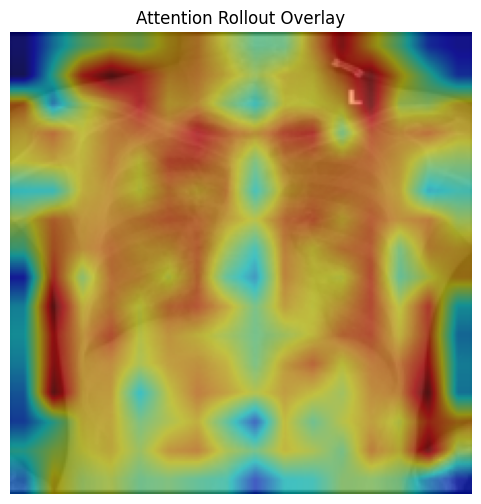

In [28]:
#Step 12F: Transform, generate attention, and visualize
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_tensor = transform(image_rgb).unsqueeze(0).to("cuda")
mask = generate_attention_rollout(model, image_tensor)
visualize_attention(image_tensor, mask)


In [29]:
#Step 13A: Save the Attention Overlay as PNG
import os
import cv2

def save_attention_overlay(image_tensor, mask, image_id="sample", save_dir="./overlays", alpha=0.5):
    """
    Save attention rollout overlay as a PNG image.

    Args:
        image_tensor: (1, 3, 224, 224) - input image tensor
        mask: (224, 224) - attention rollout mask
        image_id: string to name the output file
        save_dir: where to save the overlay
        alpha: blending factor between original and heatmap
    """
    os.makedirs(save_dir, exist_ok=True)

    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)

    save_path = os.path.join(save_dir, f"{image_id}_attention_overlay.png")
    cv2.imwrite(save_path, overlay[:, :, ::-1])  # Convert RGB to BGR for OpenCV

    print(f"[✔] Saved overlay to: {save_path}")


In [30]:
# Step 13B: Visualize Attention + Bounding Box
import matplotlib.pyplot as plt
import cv2

def visualize_with_bbox(image_tensor, mask, bbox, image_id="sample", alpha=0.5, save_path=None):
    """
    Overlay attention + draw predicted bounding box.

    Args:
        image_tensor: (1, 3, 224, 224) input image
        mask: (224, 224) attention mask
        bbox: [x, y, w, h] — values between 0 and 1
        image_id: ID for labeling or saving
        alpha: transparency of heatmap overlay
        save_path: optional path to save output
    """
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)

    # Convert to BGR for OpenCV drawing
    overlay_bgr = overlay[:, :, ::-1].copy()

    # Denormalize bbox from [0, 1] → pixel coordinates
    x, y, w, h = bbox
    x = int(x * 224)
    y = int(y * 224)
    w = int(w * 224)
    h = int(h * 224)

    # Draw rectangle (green)
    cv2.rectangle(overlay_bgr, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
    cv2.putText(overlay_bgr, f"Pred Box", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # Convert back to RGB for matplotlib
    overlay_rgb = overlay_bgr[:, :, ::-1]

    # Show and optionally save
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_rgb)
    plt.title(f"{image_id} | Attention + BBox")
    plt.axis("off")

    if save_path:
        cv2.imwrite(save_path, overlay_bgr)
        print(f"[✔] Saved attention + bbox overlay to: {save_path}")
    else:
        plt.show()


In [31]:
#Step 13C (Extended): Visualize Attention + Prediction + Ground Truth Boxes
import matplotlib.pyplot as plt
import cv2

def visualize_with_bbox_and_gt(image_tensor, mask, pred_bbox, true_bbox, image_id="sample", alpha=0.5, save_path=None):
    """
    Overlay attention + draw predicted and ground-truth bounding boxes.

    Args:
        image_tensor: (1, 3, 224, 224)
        mask: (224, 224)
        pred_bbox: [x, y, w, h] in 0–1 range
        true_bbox: [x, y, w, h] in 0–1 range
        image_id: optional string for title or filename
        alpha: transparency for heatmap
        save_path: optional file path to save the image
    """
    # Convert tensor to image
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    # Apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)
    overlay_bgr = overlay[:, :, ::-1].copy()

    # Convert bounding boxes to pixel coords
    def scale_bbox(bbox):
        x, y, w, h = bbox
        return int(x * 224), int(y * 224), int(w * 224), int(h * 224)

    px, py, pw, ph = scale_bbox(pred_bbox)
    gx, gy, gw, gh = scale_bbox(true_bbox)

    # Draw predicted box (green)
    cv2.rectangle(overlay_bgr, (px, py), (px + pw, py + ph), (0, 255, 0), 2)
    cv2.putText(overlay_bgr, "Pred", (px, py - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # Draw ground-truth box (red)
    cv2.rectangle(overlay_bgr, (gx, gy), (gx + gw, gy + gh), (255, 0, 0), 2)
    cv2.putText(overlay_bgr, "GT", (gx, gy - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # Display
    overlay_rgb = overlay_bgr[:, :, ::-1]
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_rgb)
    plt.title(f"{image_id} | Attention + BBox (Green=Pred, Red=GT)")
    plt.axis("off")

    if save_path:
        cv2.imwrite(save_path, overlay_bgr)
        print(f"[✔] Saved attention + bbox overlay to: {save_path}")
    else:
        plt.show()


In [32]:
#Step 13D: Full Batch Export Function
import os
import cv2
import torch
from tqdm import tqdm

def batch_export_attention_overlays(
    model,
    dataloader,
    tokenizer,
    transform,
    save_dir="./results/interpretability",
    num_samples=10,
    device="cuda"
):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Exporting attention overlays"):
            if count >= num_samples:
                break

            try:
                image = batch["pixel_values"].to(device)                 # (1, 3, 224, 224)
                texts = {k: v.to(device) for k, v in batch["report_inputs"].items()}
                true_bbox = batch["bboxes"][0].cpu().numpy()
                image_id = batch["meta"]["image_id"][0]

                # Run model to get prediction
                cls_logits, bbox_pred = model(image, texts)
                pred_bbox = bbox_pred[0].cpu().numpy()

                # Generate attention rollout
                mask = generate_attention_rollout(model, image)

                # Create overlay with boxes
                save_path = os.path.join(save_dir, f"{image_id}_overlay.png")
                visualize_with_bbox_and_gt(
                    image_tensor=image,
                    mask=mask,
                    pred_bbox=pred_bbox,
                    true_bbox=true_bbox,
                    image_id=image_id,
                    save_path=save_path
                )

                count += 1

            except Exception as e:
                print(f"[✗] Skipped sample due to error: {e}")


In [33]:
#step 14
# ===============================
# ✅ Step 1: Imports and Paths
# ===============================
import os
import pydicom
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTokenizer, CLIPModel

# Paths
ann_path = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
dicom_dir = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/train"

# ===============================
# ✅ Step 2: Load and Filter Annotations
# ===============================
df = pd.read_csv(ann_path)
df = df.dropna(subset=["x_min", "y_min", "x_max", "y_max", "image_id", "class_name"])
df["dicom_path"] = df["image_id"].astype(str) + ".dicom"
df["full_path"] = df["dicom_path"].apply(lambda x: os.path.join(dicom_dir, x))
df = df[df["full_path"].apply(os.path.exists)]

# ✅ Limit to 2000 annotated samples
df = df.sample(n=2000, random_state=42).reset_index(drop=True)
print(f"📊 Total selected annotated DICOMs: {len(df)}")

# ===============================
# ✅ Step 3: Tokenizer
# ===============================
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# ===============================
# ✅ Step 4: Dataset Definition
# ===============================
class VinDrTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["full_path"]
        label = str(row["class_name"])

        dicom = pydicom.dcmread(image_path)
        img_arr = dicom.pixel_array.astype(np.uint8)
        orig_w, orig_h = img_arr.shape[1], img_arr.shape[0]

        pil_image = Image.fromarray(img_arr).convert("RGB").resize((224, 224))
        image_tensor = ToTensor()(pil_image)

        x = row["x_min"] / orig_w * 224
        y = row["y_min"] / orig_h * 224
        w = (row["x_max"] - row["x_min"]) / orig_w * 224
        h = (row["y_max"] - row["y_min"]) / orig_h * 224
        bbox = torch.tensor([x, y, w, h], dtype=torch.float32)

        return {
            "pixel_values": image_tensor,
            "label_text": label,
            "bbox": bbox
        }

# ===============================
# ✅ Step 5: Custom Collate Function
# ===============================
def custom_collate(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    bboxes = torch.stack([item["bbox"] for item in batch])
    label_texts = [item["label_text"] for item in batch]

    report_inputs = tokenizer(
        label_texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    return {
        "pixel_values": pixel_values,
        "bbox": bboxes,
        "report_inputs": report_inputs
    }

# ===============================
# ✅ Step 6: DataLoader
# ===============================
train_dataset = VinDrTrainDataset(df)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate
)

# ===============================
# ✅ Step 7: Dummy Model (Replace with your own)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model
        self.fc = torch.nn.Linear(768, 4)

    def forward(self, images, texts):
        img_feat = self.encoder(pixel_values=images).last_hidden_state[:, 0, :]
        return self.fc(img_feat), None

model = DummyModel().to(device)

# ===============================
# ✅ Step 8: Training Setup
# ===============================
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

# ===============================
# ✅ Step 9: Training Loop
# ===============================
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = batch["pixel_values"].to(device)
        targets = batch["bbox"].to(device)
        texts = {k: v.to(device) for k, v in batch["report_inputs"].items()}

        optimizer.zero_grad()
        pred_bbox, _ = model(images, texts)

        loss = criterion(pred_bbox, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"✅ Epoch {epoch+1} | Avg Loss: {running_loss / len(train_dataloader):.4f}")


📊 Total selected annotated DICOMs: 2000


Epoch 1/5: 100%|██████████| 250/250 [1:15:26<00:00, 18.10s/it]


✅ Epoch 1 | Avg Loss: 1628.1375


Epoch 2/5: 100%|██████████| 250/250 [31:07<00:00,  7.47s/it]


✅ Epoch 2 | Avg Loss: 1441.2765


Epoch 3/5: 100%|██████████| 250/250 [31:07<00:00,  7.47s/it]


✅ Epoch 3 | Avg Loss: 1444.5359


Epoch 4/5: 100%|██████████| 250/250 [31:07<00:00,  7.47s/it]


✅ Epoch 4 | Avg Loss: 1441.7262


Epoch 5/5: 100%|██████████| 250/250 [31:09<00:00,  7.48s/it]

✅ Epoch 5 | Avg Loss: 1433.2083


📊 Valid annotated DICOMs found: 4522


✅ Final Predicted Box: [83.71279907226562, 75.51509857177734, 35.255859375, 26.939224243164062]
✅ Ground Truth Box (scaled): [np.float64(110.22005859374892), np.float64(48.08466622042803), np.float64(49.136129807692306), np.float64(57.62285331082107)]
📏 IoU between prediction and GT: 0.0665


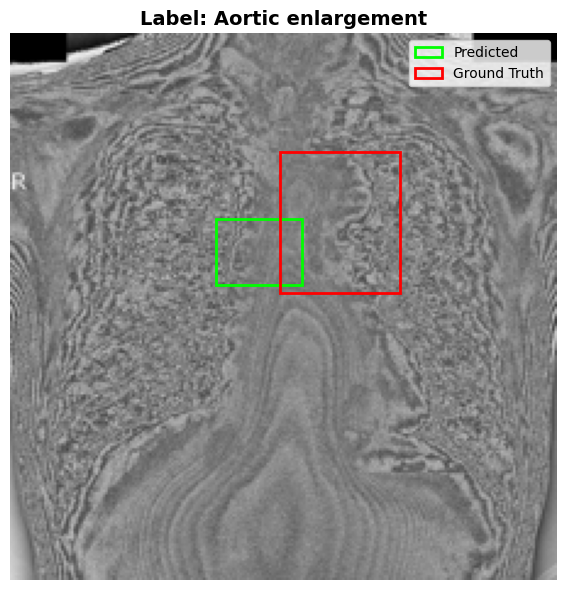

In [34]:
#step  15
!pip install -q pydicom

# ✅ Step 1: Imports
import os
import pydicom
import pandas as pd
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import ToTensor
from transformers import CLIPTokenizer

# ✅ Step 2: Paths
ann_path = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
dicom_dir = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/train"

# ✅ Step 3: Load annotations
df = pd.read_csv(ann_path)
df = df.dropna(subset=["x_min", "y_min", "x_max", "y_max", "image_id", "class_name"])
df["dicom_path"] = df["image_id"].astype(str) + ".dicom"
df["full_path"] = df["dicom_path"].apply(lambda x: os.path.join(dicom_dir, x))
df = df[df["full_path"].apply(os.path.exists)]

print(f"📊 Valid annotated DICOMs found: {df['image_id'].nunique()}")

# ✅ Step 4: Randomly sample
row = df.sample(n=1).iloc[0]
dicom_path = row["full_path"]
label = str(row["class_name"])
image_id = row["image_id"]

# ✅ Step 5: Load and resize image
dicom = pydicom.dcmread(dicom_path)
image_array = dicom.pixel_array.astype(np.uint8)

# Convert to 3-channel RGB PIL image
image_pil = Image.fromarray(image_array).convert("RGB").resize((224, 224))
image_tensor = ToTensor()(image_pil).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Step 6: Tokenize label and predict
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_inputs = tokenizer(label, return_tensors="pt", padding=True, truncation=True).to(image_tensor.device)
model.eval()
with torch.no_grad():
    pred_bbox = model(image_tensor, text_inputs)[0]

# ✅ Step 7: Ground Truth scaling from original shape to 224x224
orig_w, orig_h = image_array.shape[1], image_array.shape[0]
gt_box = [
    row["x_min"] / orig_w * 224,
    row["y_min"] / orig_h * 224,
    (row["x_max"] - row["x_min"]) / orig_w * 224,
    (row["y_max"] - row["y_min"]) / orig_h * 224
]

# ✅ Step 8: Postprocess prediction
pred_box = pred_bbox.cpu().numpy()
if pred_box.ndim > 1:
    pred_box = pred_box[0]
pred_box = pred_box.tolist()

if len(pred_box) == 2:
    box_w, box_h = 40, 40
    pred_box = [
        (pred_box[0] + 1) / 2 * 224 - box_w / 2,
        (pred_box[1] + 1) / 2 * 224 - box_h / 2,
        box_w,
        box_h
    ]

if len(pred_box) != 4:
    print("❌ Invalid predicted box:", pred_box)
    pred_box = None
else:
    print("✅ Final Predicted Box:", pred_box)

print("✅ Ground Truth Box (scaled):", gt_box)

# ✅ Step 9: Compute IoU
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-5)
    return round(iou, 4)

if pred_box:
    iou = compute_iou(pred_box, gt_box)
    print(f"📏 IoU between prediction and GT: {iou}")
else:
    print("⚠️ Skipped IoU due to invalid prediction.")

# ✅ Step 10: Plot both boxes
def plot_prediction_vs_ground_truth(img, label, pred_box, gt_box):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img)
    ax.set_title(f"Label: {label}", fontsize=14, fontweight='bold')

    if pred_box:
        ax.add_patch(patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                       linewidth=2, edgecolor='lime', facecolor='none', label='Predicted'))
    if gt_box:
        ax.add_patch(patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2], gt_box[3],
                                       linewidth=2, edgecolor='red', facecolor='none', label='Ground Truth'))

    ax.legend(loc='upper right')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_prediction_vs_ground_truth(image_pil, label, pred_box, gt_box)


📊 Valid annotated DICOMs: 4522
[15618] Pleural thickening — IoU: 0.0


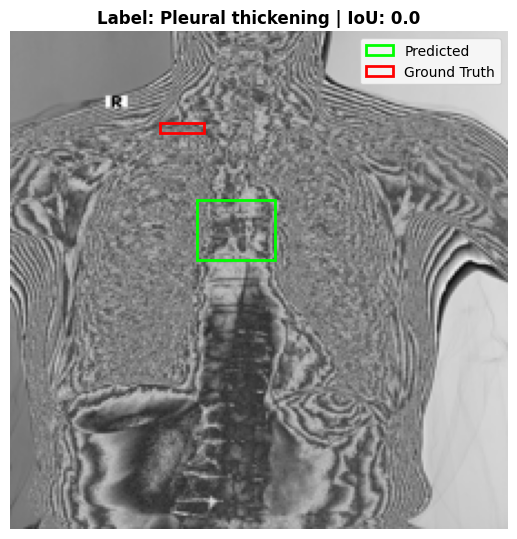

[42065] Aortic enlargement — IoU: 0.0


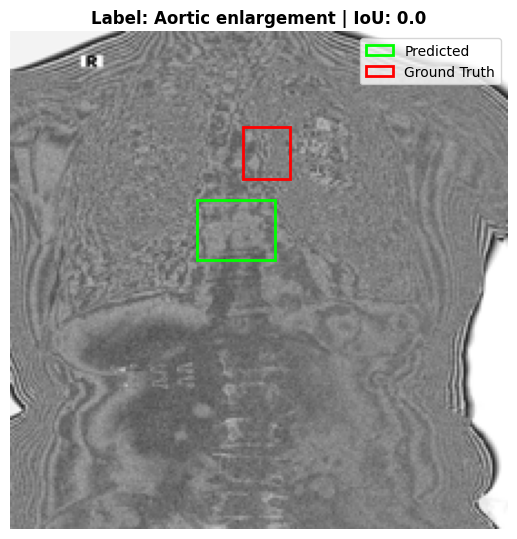

[3064] Cardiomegaly — IoU: 0.0


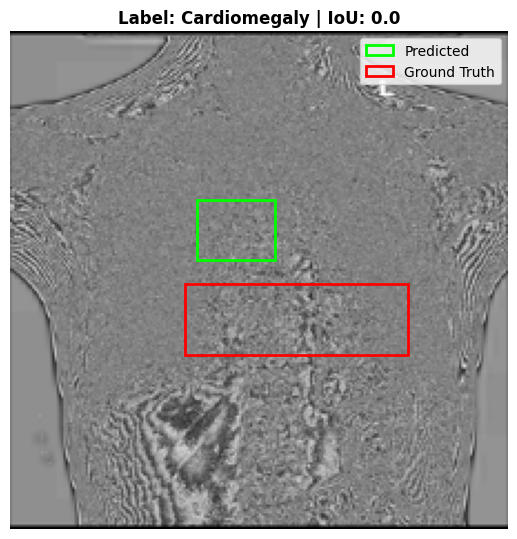

[52920] Aortic enlargement — IoU: 0.1053


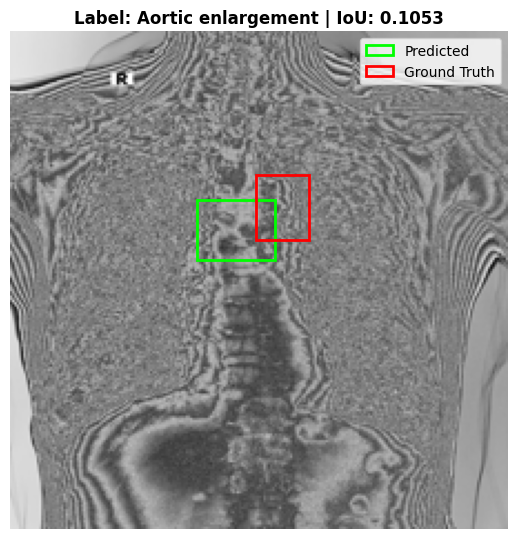

[4744] Aortic enlargement — IoU: 0.0655


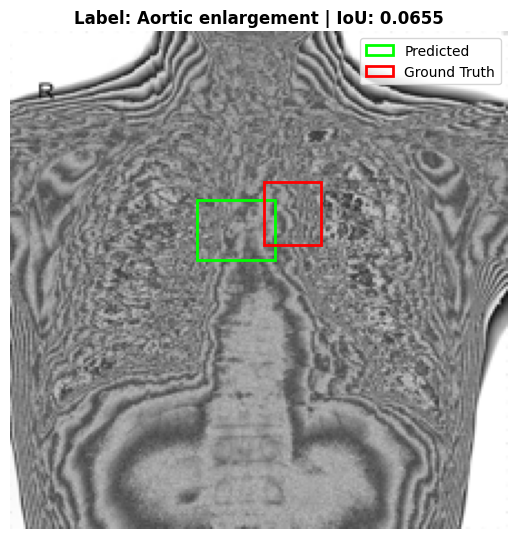

[51165] Pulmonary fibrosis — IoU: 0.0


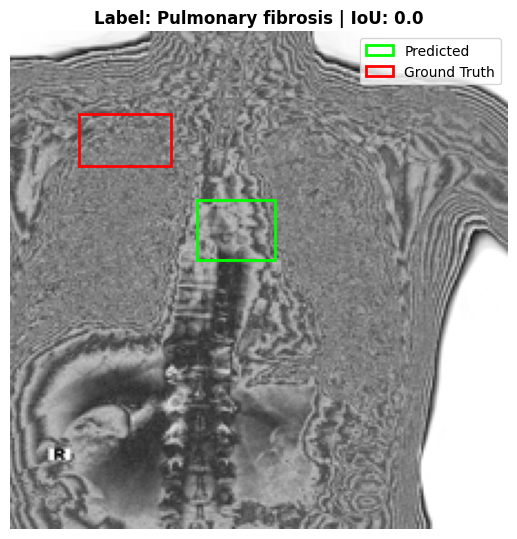

[15915] Cardiomegaly — IoU: 0.0


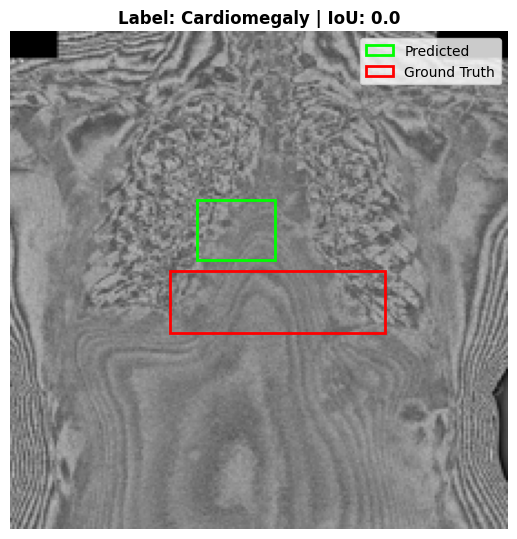

[23365] Pleural thickening — IoU: 0.0


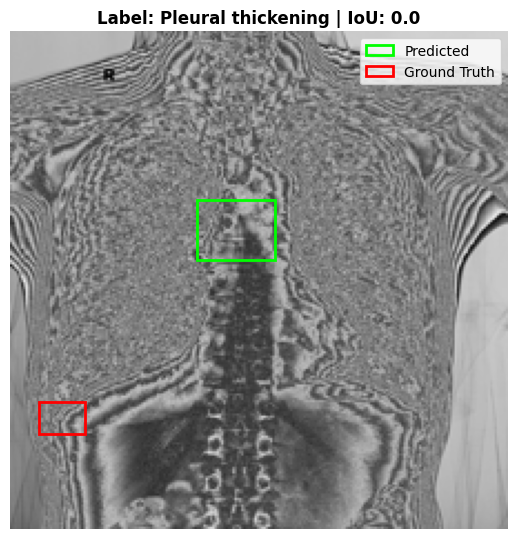

[32942] Aortic enlargement — IoU: 0.1213


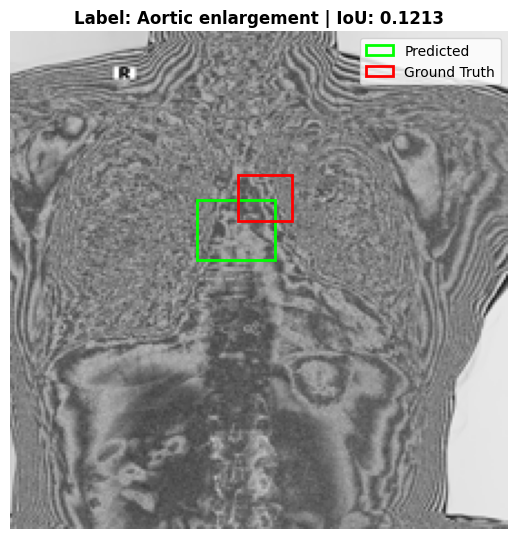

[67948] Atelectasis — IoU: 0.0


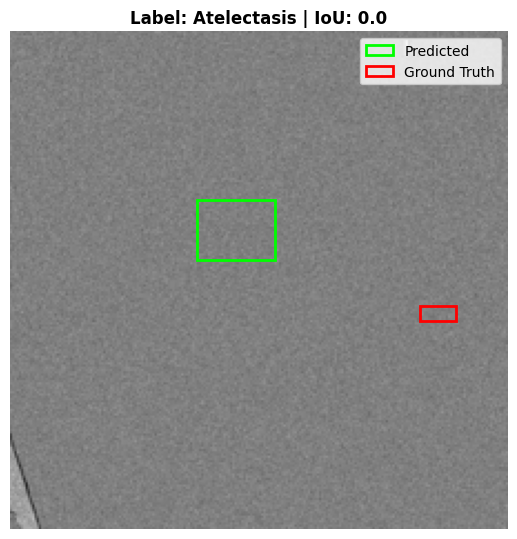

[25596] Pleural effusion — IoU: 0.0


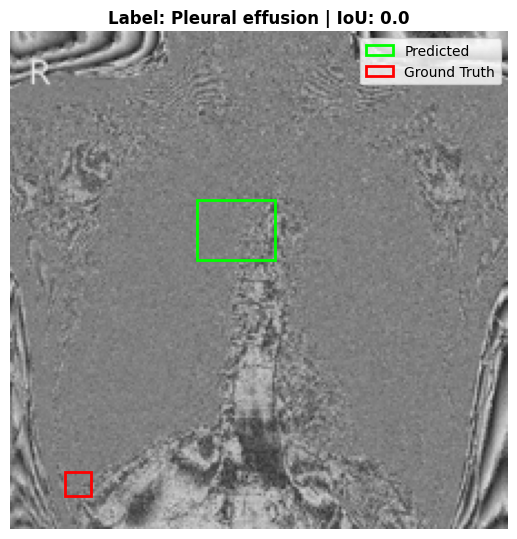

[41378] Cardiomegaly — IoU: 0.0


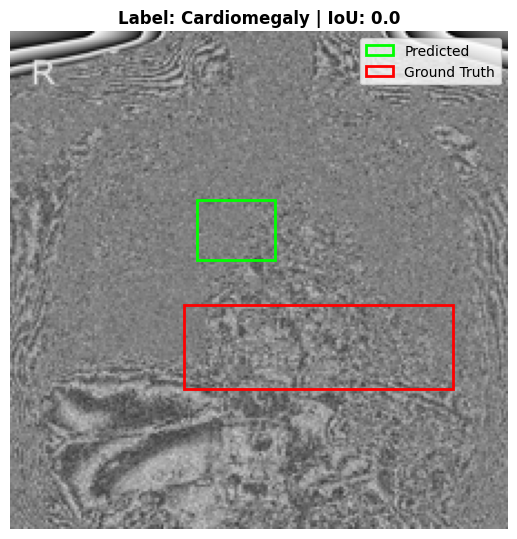

[17789] Infiltration — IoU: 0.0


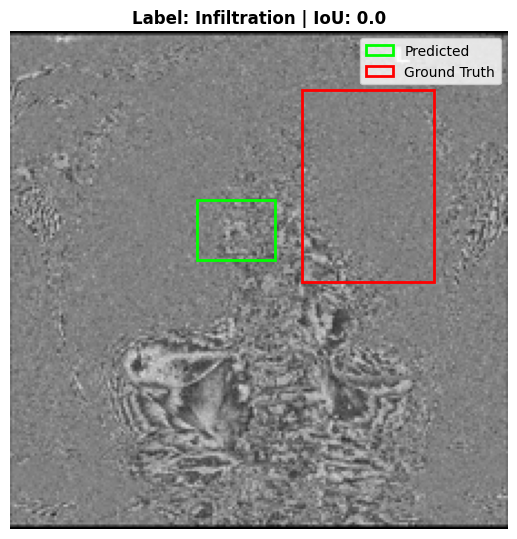

[45652] Pulmonary fibrosis — IoU: 0.0


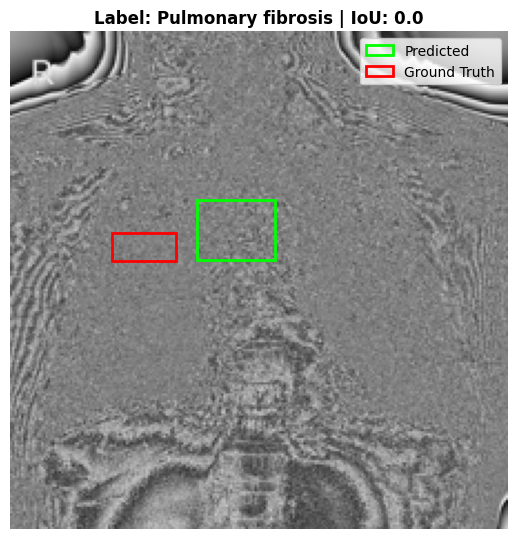

[11761] Pleural thickening — IoU: 0.0


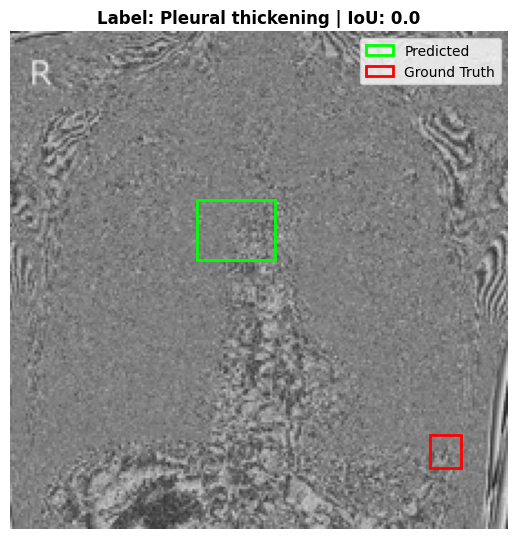

[68072] Pulmonary fibrosis — IoU: 0.0


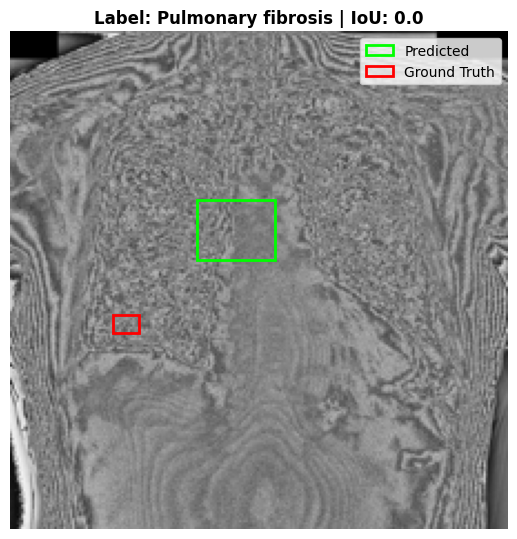

[12717] Cardiomegaly — IoU: 0.0


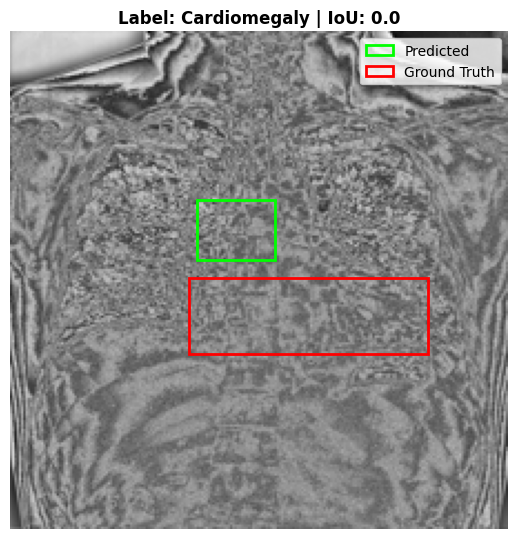

[14642] Cardiomegaly — IoU: 0.0


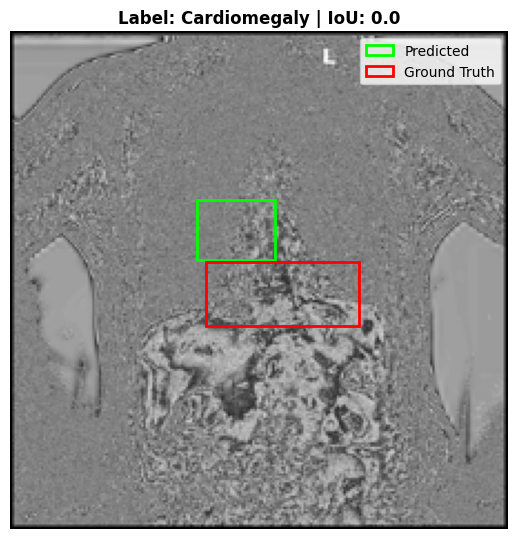

[21688] Pleural effusion — IoU: 0.0


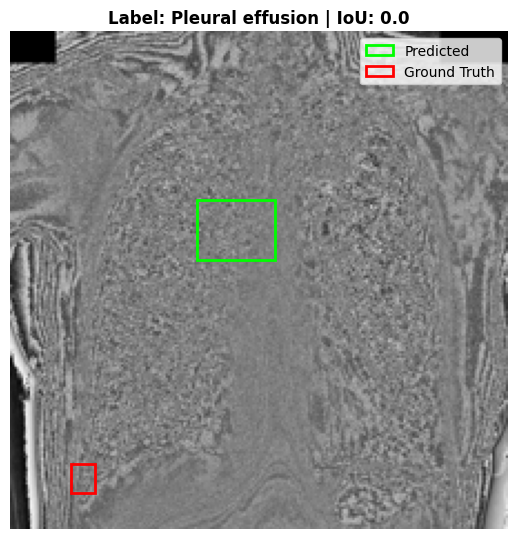

[66862] Pleural thickening — IoU: 0.0


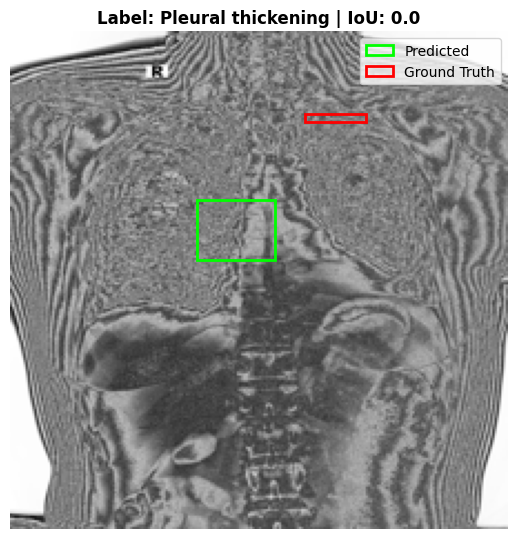


📈 Processed 20/20 images
📊 Average IoU: 0.0146


In [35]:
#step 16
#Code (Colab-ready — Loop over N samples)
import os
import pydicom
import pandas as pd
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import ToTensor
from transformers import CLIPTokenizer

# ✅ Paths
ann_path = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
dicom_dir = "/content/drive/MyDrive/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/train"

# ✅ Load annotation CSV
df = pd.read_csv(ann_path)
df = df.dropna(subset=["x_min", "y_min", "x_max", "y_max", "image_id", "class_name"])
df["dicom_path"] = df["image_id"].astype(str) + ".dicom"
df["full_path"] = df["dicom_path"].apply(lambda x: os.path.join(dicom_dir, x))
df = df[df["full_path"].apply(os.path.exists)]

print(f"📊 Valid annotated DICOMs: {df['image_id'].nunique()}")

# ✅ Init tokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# ✅ IoU function
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-5)
    return round(iou, 4)

# ✅ Visualization function (optional toggle)
def plot_overlay(img, label, pred_box, gt_box, iou):
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label} | IoU: {iou}", fontsize=12, fontweight='bold')

    if pred_box:
        ax.add_patch(patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                       linewidth=2, edgecolor='lime', facecolor='none', label='Predicted'))
    if gt_box:
        ax.add_patch(patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2], gt_box[3],
                                       linewidth=2, edgecolor='red', facecolor='none', label='Ground Truth'))

    ax.legend(loc='upper right')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Main loop
num_samples = 20
ious = []
valid_preds = 0

sampled_df = df.sample(n=num_samples)

for i, row in sampled_df.iterrows():
    dicom_path = row["full_path"]
    label = str(row["class_name"])
    image_id = row["image_id"]

    try:
        dicom = pydicom.dcmread(dicom_path)
        img_arr = dicom.pixel_array.astype(np.uint8)
        orig_w, orig_h = img_arr.shape[1], img_arr.shape[0]

        pil_image = Image.fromarray(img_arr).convert("RGB").resize((224, 224))
        image_tensor = ToTensor()(pil_image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

        # Scale GT box to 224x224
        gt_box = [
            row["x_min"] / orig_w * 224,
            row["y_min"] / orig_h * 224,
            (row["x_max"] - row["x_min"]) / orig_w * 224,
            (row["y_max"] - row["y_min"]) / orig_h * 224
        ]

        # Prediction
        text_inputs = tokenizer(label, return_tensors="pt", padding=True, truncation=True).to(image_tensor.device)
        model.eval()
        with torch.no_grad():
            pred_bbox = model(image_tensor, text_inputs)[0]

        pred_box = pred_bbox.cpu().numpy()
        if pred_box.ndim > 1:
            pred_box = pred_box[0]
        pred_box = pred_box.tolist()

        if len(pred_box) == 2:
            box_w, box_h = 40, 40
            pred_box = [
                (pred_box[0] + 1) / 2 * 224 - box_w / 2,
                (pred_box[1] + 1) / 2 * 224 - box_h / 2,
                box_w,
                box_h
            ]

        if len(pred_box) != 4:
            print(f"⚠️ Skipping {image_id} — invalid prediction: {pred_box}")
            continue

        iou = compute_iou(pred_box, gt_box)
        ious.append(iou)
        valid_preds += 1

        print(f"[{i+1}] {label} — IoU: {iou}")
        plot_overlay(pil_image, label, pred_box, gt_box, iou)

    except Exception as e:
        print(f"[✗] Skipped {image_id} — Error: {e}")
        continue

# ✅ Results
if valid_preds > 0:
    avg_iou = sum(ious) / valid_preds
    print(f"\n📈 Processed {valid_preds}/{num_samples} images")
    print(f"📊 Average IoU: {round(avg_iou, 4)}")
else:
    print("⚠️ No valid predictions to evaluate.")
